In [ ]:
import numpy as np
import pandas as pd

import os

#------------------------------------

import poseigen_seaside.basics as se
import poseigen_seaside.visuals as viz

import poseigen_chisel as chis

import poseigen_trident.utils as tu

import poseigen_oyster.analysis as interp

In [5]:
data_path = "../data/R3/"
os.makedirs(data_path, exist_ok=True)

os.chdir(data_path)

In [18]:
fin_bins = se.PickleLoad('fin_bins')
print(fin_bins)

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps_4')

tablesfolder = se.NewFolder('tables')

#---------------------------------------

histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2A.Z', 'H3K79me2']

#---------------------------------------

yy1_split_transaug = se.PickleLoad('yy1_split_transaug')

yy1_max = se.PickleLoad('yy1_max')

tri_tpacks = se.PickleLoad('tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

#---------------------------------------

RO_folder = se.NewFolder('RO')

ex_oys_folder = se.NewFolder(RO_folder + 'exact')
oys_iter = 11
pn_RO_exact = se.NewFolder(ex_oys_folder + 'RO_' + str(oys_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

#---------------------------------------

xpHIS_trial = 8                                                         #@@@@@@@@@@@@@@
xpHIS_id = 'xpHIS' + '_' + str(xpHIS_trial) 
pn_xpHIS = se.NewFolder(xpsfolder + xpHIS_id)
pn_xpF, icof, icom = pn_xpHIS, 0, 1                                     #@@@@@@@@@@@@@@

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]



#---------------------------------------------

# BECAUSE WE REFINED!!!!!!!!

hiscombo =[0, 1, 2, 3, 6, 9]

histones = np.array(histones)[hiscombo]

exact_dict['B_dim_i'] = (4, exact_dict['B_dim_i'][1], exact_dict['B_dim_i'][2])

d_x2 = d_x2[:, hiscombo]
print(d_x2.shape)


#-----------------------------------------------

tablesfolder = se.NewFolder(pn_t2 + 'tables')
tablesfolder

10
(60000, 6, 40, 1)


'./xps_4/xpHIS_8/0/1/tables/'

In [ ]:
import openpyxl
from openpyxl.styles import Border, Side

def table_styler(styler):
    return styler.set_properties(**{
        'font-family': 'Times New Roman',
        'font-size': '11pt',
        'text-align': 'center'
    })

def table_saver(table, out_path):

    out_path = tablesfolder + 'sum_motifs.xlsx'
    table.to_excel(out_path)
    
    wb = openpyxl.load_workbook(out_path)
    ws = wb.active

    thin = Side(border_style="thin", color="000000")
    border = Border(left=thin, right=thin, top=thin, bottom=thin)

    for row in ws.iter_rows():
        for cell in row:
            cell.border = border

    wb.save(out_path)

    return

## Motifs 

In [11]:
tomain = '../../../../../'
human_core_motifs = tomain + 'Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
motif_names_unfilt, motif_mats = chis.MEME2Motifs(human_core_motifs, name_idx = name_idx)

motif_lengths = np.array([len(x) for x in motif_mats])

motif_names = [a.split('_HUMAN')[0] for a in motif_names_unfilt]

motif_names_revcomp = [x + '_R' for x in motif_names]
motif_mats_revcomp = [np.flip(x, (-1, -2)) for x in motif_mats]

##################################

include_revcomp = not exact_dict['A_DS']

if include_revcomp: 

    motif_names_revcomp = [x + '_R' for x in motif_names]
    motif_mats_revcomp = [np.flip(x, (-1, -2)) for x in motif_mats]

    motif_names, motif_mats = [x + y for x,y in [[motif_names, motif_names_revcomp], 
                                                [motif_mats, motif_mats_revcomp]]]
    motif_lengths = np.hstack([motif_lengths, motif_lengths])

else: 

    motif_names, motif_mats = [motif_names, motif_mats]
    motif_lengths = motif_lengths


##################################

yy1_motif_idx = motif_names.index('TYY1')

# yy1_motif = motif_mats[yy1_motif_idx]
# PickleDump(yy1_motif, "yy1_motif")
# LogomakerFromNumpy(yy1_motif)

##################################

### Motif Similarity

In [19]:
meto = 'euc'
fo, ass = (np.min, True) if meto == 'euc' else (np.max, False)


yy1_motif = motif_mats[yy1_motif_idx]

yy1_dotmax = np.sum(yy1_motif * yy1_motif)

yy1_sim = []

for am in motif_mats: 

    sc = chis.PWMScorer(yy1_motif, am,
                      revcomp = True, sepwindows = True, extendbig = True, 
                      score_mode=meto) #############
    
    yy1_sim.append(fo(sc)) #####################


yy1_sim_ms = se.Scaler(np.array(yy1_sim)) # / yy1_dotmax

yy1_sim_pd = pd.DataFrame(yy1_sim_ms, columns = ['YY1 Similarity'])
yy1_sim_pd.index = motif_names
yy1_sim_pd.index.name = 'Motif'
yy1_sim_pd = yy1_sim_pd.sort_values('YY1 Similarity', ascending= ass, ignore_index=False)

yy1_sim_pd.to_excel('yy1_sim_pd.xlsx')
                          
yy1_sim_pd[:20]

,YY1 Similarity
Motif,
TYY1_R,0.000000
TYY1,0.000000
ZFP42,0.334290
ZFP42_R,0.334290
THAP1,0.440191
THAP1_R,0.440191
TAF1,0.569625
TAF1_R,0.569625
SOX17,0.697118


In [9]:
# plt.plot(np.sort(yy1_sim_ms))
# plt.axhline(0.6)

### k-motifs

In [13]:
kppm_names, kppm_mats = [], []

kppm_idxs = []

idx_counter = 0
for n,m in zip(motif_names, motif_mats):
    
    shifm, shifn = chis.kPPMFromPPM(m, k = exact_dict['A_kE_k'], name = n)
    kppm_names.extend(shifn)
    kppm_mats.extend(shifm)

    lenoz = len(shifn)

    kppm_idxs.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(kppm_mats), len(kppm_names))

4054 4054


In [8]:
ppmcont_args = {'sub_model': 'OysterA', 'joint': exact_dict['A_DS'], 
                'random_seqs': 10000, 'unique': True, 
                'scoreweight': True, 'score_mode': 'recipeuc',
                'batchsize': 8192}

kppm_scores = []

for ip, kppm in enumerate(kppm_mats): 
    kppm_scores.append(interp.kppm_contrib(ex_ens_pn_mods, kppm, **ppmcont_args))
    if ip % 10 == 0: print(f'finished {ip}')

kppm_scores = np.squeeze(np.stack(kppm_scores))

se.PickleDump(kppm_scores, pn_t2 + 'kppm_scores')

finished 0
finished 10
finished 20
finished 30
finished 40
finished 50
finished 60
finished 70
finished 80
finished 90
finished 100
finished 110
finished 120
finished 130
finished 140
finished 150
finished 160
finished 170
finished 180
finished 190
finished 200
finished 210
finished 220
finished 230
finished 240
finished 250
finished 260
finished 270
finished 280
finished 290
finished 300
finished 310
finished 320
finished 330
finished 340
finished 350
finished 360
finished 370
finished 380
finished 390
finished 400
finished 410
finished 420
finished 430
finished 440
finished 450
finished 460
finished 470
finished 480
finished 490
finished 500
finished 510
finished 520
finished 530
finished 540
finished 550
finished 560
finished 570
finished 580
finished 590
finished 600
finished 610
finished 620
finished 630
finished 640
finished 650
finished 660
finished 670
finished 680
finished 690
finished 700
finished 710
finished 720
finished 730
finished 740
finished 750
finished 760
finished 7

In [ ]:
kppm_scores = se.PickleLoad(pn_t2 + 'kppm_scores')
mino, maxo = (np.round(f(kppm_scores),4) for f in [np.min, np.max])
print(mino, maxo)

# Set columns to 1-based labels
poss = np.arange(len(kppm_scores.T))
col_labels = poss + 1  # 1-based

pdo = pd.DataFrame(data = np.array(kppm_names), columns = ['k-Motif'])
pdo = pd.concat([pdo, pd.DataFrame(kppm_scores, columns=col_labels)], axis=1)

kppm_scores_maxs2 = np.max(kppm_scores, axis = 1)
sorto = np.argsort(np.abs(kppm_scores_maxs2))[::-1]
pdx = pdo.iloc[sorto]

# Round numeric columns to 3 decimals
for col in col_labels:
    pdx[col] = pdx[col].astype(float).round(3)

pdx_sty = pdx.style.format(precision=3) \
    .background_gradient(cmap='Grays', axis=None, subset=col_labels, vmin=mino, vmax=maxo)
pdx_sty = table_styler(pdx_sty)

out_path = tablesfolder + 'k_motifs.xlsx'
table_saver(pdx_sty, out_path)

-0.0015 0.0582


#### Summarized Motifs

In [22]:
kppm_scores = se.PickleLoad(pn_t2 + 'kppm_scores')

kppm_scores_exp = interp.contrib_perpos(kppm_scores, exact_dict, submodel= 'A')

sppm_scores = interp.sppm_contrib(kppm_scores_exp, kppm_idxs)

sppm_scores_arc = interp.sppm_avgrevcomp(sppm_scores) #average revcomp
sppm_scores_filld = interp.contrib_fill(sppm_scores_arc, exact_dict['A_dim_i'][1], 
                                        fill_center = False) #!!!!

In [23]:
sppm_scores_absmax = np.nanmax(np.abs(sppm_scores_filld), axis = -1)


sorto = np.argsort(sppm_scores_absmax)[::-1]
thresh = 0.01
ot = np.where(sppm_scores_absmax.reshape(-1) > thresh)[0]
filt = np.array([s for s in sorto if s in ot])

sppm_scores_filt, motif_names_filt = [x[filt] for x in [sppm_scores_filld, np.array(motif_names)]]

motif_names_filt

array(['TYY1', 'ZFP42', 'HXB4', 'RFX1'], dtype='<U7')

In [24]:
sppm_scores_absmax.max()

np.float64(0.16651593550246316)

In [25]:
sxpd = pd.DataFrame(data = sppm_scores_filld, columns = np.arange(exact_dict['A_dim_i'][1]))
sxpd.index = motif_names[:len(motif_names) // 2]
sxpd.index.name = 'Motif'

sxpd = sxpd.iloc[sorto]

sxpd.to_excel(tablesfolder + 'sxpd.xlsx')

In [ ]:
# Set columns to 1-based labels
col_labels = np.arange(1, sxpd.shape[1] + 1)
sxpd.columns = col_labels

# Round numeric columns to 3 decimals
for col in col_labels:
    sxpd[col] = sxpd[col].astype(float).round(3)

def style_sxpd(styler):
    return styler.set_properties(**{
        'font-family': 'Times New Roman',
        'font-size': '11pt',
        'text-align': 'center'
    })

# Apply background gradient if desired
sxpd_sty = sxpd.style.format(precision=3) \
    .background_gradient(cmap='Grays', axis=None, subset=col_labels)
sxpd_sty = table_styler(sxpd_sty)

out_path = tablesfolder + 'sum_motifs.xlsx'
table_saver(sxpd_sty, out_path)

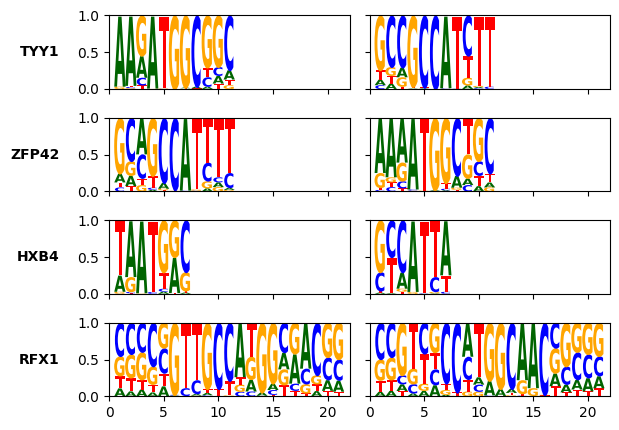

In [27]:
def QuickExtend(m, finsize = 10): 
       return np.vstack([m, np.zeros((finsize-len(m), 4))]) if len(m) <= finsize else m

#---------------------------------

motif_maxsize = np.max([len(motif_mats[f]) for f in filt])

motifs_display = [[QuickExtend(motif_mats[f], motif_maxsize), 
                   QuickExtend(np.flip(motif_mats[f], axis = (0,1)), motif_maxsize)] 
                   for f in filt]


viz.MultiPlot(motifs_display, plt_mode = [viz.LogoPlot, {'xticks': False, 'ylabel': None}],
          multi = True, paired = True, transpose = True,
          rowtitle = motif_names_filt, rowtitle_rotation = False,
          sharex = True, sharey = True, 
          figsize = (motif_maxsize * 0.3, len(filt) * 1.1));

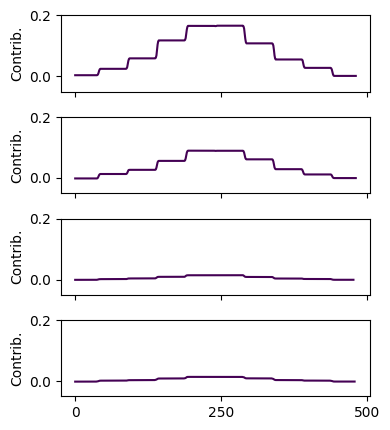

In [28]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 
           'rowtitle_rotation': False,
           'figsize': (4, len(filt) * 1.1), 'fontsize': 10,
           'sharey': True, 'sharex': True}

nucseqlen = 500

line_args = {'xticklabel': [0, nucseqlen // 2, nucseqlen], 
             'bounds': [np.nanmin(sppm_scores_filt) * 1.05, np.nanmax(sppm_scores_filt)* 1.05],
             'xlabel': None, 'ylabel': 'Contrib.', 
             'bounds': [-0.05, 0.2]}


viz.MultiPlot(sppm_scores_filt, **mp_args, customgrid=None,
                 plt_mode = [viz.LinePlot, line_args]);

# Histones

In [15]:
sep_histones = False

In [ ]:
k_size = exact_dict['B_kE_k']

his_signals_win_k = tu.TridentWindow(d_x2, k_size)
se.PickleDump(his_signals_win_k, pn_t2 + 'his_signals_win_k')

from sklearn.cluster import KMeans

his_signals_k_clustered = interp.kmer_cluster(his_signals_win_k, 
                                            H_size = k_size, 
                                            num_clusters = 500, 
                                            sample = 1000000, 
                                            chunk = sep_histones, 
                                            cluster_mode = [KMeans, {}])
# SHAPE IS (NUM KMERS, NUM HSITONES (IF CHUNKED))

se.PickleDump(his_signals_k_clustered,  pn_t2 + 'his_signals_k_clustered')

In [ ]:
S_refine = 1

if sep_histones: 

    his_signals_k_clustered_ref = interp.cluster_refine_per_histone(his_signals_win_k[:, :, :, 0], 
                                                                his_signals_k_clustered, 
                                                                S = S_refine)

else: 

    his_signals_k_clustered_ref = interp.cluster_refine(his_signals_win_k[:, :, :, 0], 
                                                                his_signals_k_clustered, 
                                                                S = S_refine)

se.PickleDump(his_signals_k_clustered_ref, pn_t2 + 'his_signals_k_clustered_ref')

from 500 to 33


In [5]:
his_signals_win_k = se.PickleLoad(pn_t2 + 'his_signals_win_k')

his_signals_k_contrib = interp.kmer_contrib_multi(ex_ens_pn_mods, his_signals_win_k,
                                                sub_model = 'OysterB', 
                                                joint = exact_dict['B_DS'], 
                                                chunk = sep_histones, 
                                                batchsize = 63768)

# SHAPE IS (NUM KMERS, 1, NUM HISTONES,  NUM POSITIONS, 1)

se.PickleDump(his_signals_k_contrib, pn_t2 + 'ensemble_' + 'his_signals_k_contrib')

In [63]:
his_signals_win_k = se.PickleLoad(pn_t2 + 'his_signals_win_k')
his_signals_k_clustered_ref = se.PickleLoad(pn_t2 + 'his_signals_k_clustered_ref')
his_signals_k_contrib = se.PickleLoad(pn_t2 + 'ensemble_' + 'his_signals_k_contrib') ###################

his_signals_k_contrib_2 = his_signals_k_contrib[:, 0] if sep_histones else his_signals_k_contrib

his_signals_k_centroids = interp.centroid_contrib(his_signals_win_k, his_signals_k_contrib_2, 
                                                his_signals_k_clustered_ref, 
                                                weighted = True, score_mode = 'recipeuc', 
                                                chunk = sep_histones, return_centroids = True)

se.PickleDump(his_signals_k_centroids,  pn_t2 + 'ensemble_' + 'his_signals_k_centroids')

In [17]:
his_signals_k_centroids = se.PickleLoad(pn_t2 + 'ensemble_' + 'his_signals_k_centroids')

cents, cents_contribs = his_signals_k_centroids

cents_contribs_perpos = interp.contrib_perpos(cents_contribs, 
                                              exact_dict, submodel = 'B')

cents_contribs_perpos_filld = interp.contrib_fill(cents_contribs_perpos[:, :, 0], 
                                           exact_dict['B_dim_i'][1], 
                                           fill_with = np.nan, fill_center = False)

his_absmaxs = np.max(np.abs(cents_contribs_perpos[:, :, 0]), axis = 1)
his_sort = np.argsort(his_absmaxs)[::-1]

cents_sortd, cents_contribs_sortd = [x[his_sort] for x in [cents, cents_contribs_perpos_filld]]

his_ot = his_absmaxs[his_sort] > 0.01

cents_ot, cents_contribs_ot = [x[his_ot] for x in [cents_sortd, cents_contribs_sortd]]

print(len(cents_ot))

2


In [ ]:
import pandas as pd
import openpyxl
from openpyxl.styles import Border, Side

# Create DataFrame with 1-based row and column labels
row_labels = np.arange(1, cents_contribs_sortd.shape[0] + 1)
col_labels = np.arange(1, cents_contribs_sortd.shape[1] + 1)

df = pd.DataFrame(cents_contribs_sortd, index=row_labels, columns=col_labels)
df.index.name = "histone k-pattern"

# Round to 3 decimals
for col in col_labels:
    df[col] = df[col].astype(float).round(3)

# Apply background gradient if desired
sty = df.style.format(precision=3) \
    .background_gradient(cmap='Greys', axis=None, subset=col_labels)
sty = table_styler(sty)

out_path = tablesfolder + 'histone_kpat_contribs.xlsx'
table_saver(sty, out_path)

tables/histone_kpat_contribs.xlsx


In [ ]:
import pandas as pd
import numpy as np
import openpyxl
from openpyxl.styles import Border, Side

# Assume histones is a list of 4 histone names
# cents_sortd shape: (22, 4, 10, 1)
arr = np.squeeze(cents_sortd, axis=-1)  # shape: (22, 4, 10)

# Prepare MultiIndex columns
histone_names = list(histones)  # should be length 4
col_tuples = []
for h in histone_names:
    for i in range(1, 11):
        col_tuples.append((h, i))
multi_cols = pd.MultiIndex.from_tuples(col_tuples, names=["Histone", "Position"])

# Flatten for DataFrame
arr_flat = arr.reshape(arr.shape[0], -1)
row_labels = np.arange(1, arr.shape[0] + 1)

df = pd.DataFrame(arr_flat, index=row_labels, columns=multi_cols)
df.index.name = "histone k-pattern"

# Round to 3 decimals
df = df.round(3)


# Background gradient per histone block
sty = df.style.format(precision=3)
for h in histone_names:
    sty = sty.background_gradient(cmap='Greys', axis=None, subset=pd.IndexSlice[:, pd.IndexSlice[h, :]])
sty = table_styler(sty)

out_path = tablesfolder + 'histone_kpat_cents.xlsx'
table_saver(sty, out_path)

tables/histone_kpat_cents.xlsx


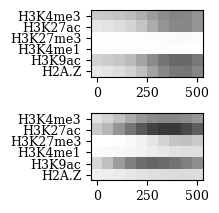

In [21]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (4, len(cents_contribs_ot) * 1.1), 'fontsize': 9,
           'sharey': True, 'sharex': False}

his_h_size = exact_dict['B_kE_k']

gp_args = {'xticklabel': [0, int(his_h_size*50 / 2), his_h_size*50], 
             'xlabel': None, 'ylabel': None, 
             'yticklabel': histones, 
             'bounds': [0, 1.0], 'colorbar': False, 'cmap': 'Grays'}


if len(cents_ot) > 1: 
   ax = viz.MultiPlot(cents_ot[:, :, :, 0], **mp_args, 
               customgrid=(len(cents_contribs_ot), 1),
                  plt_mode = [viz.GridPlot, gp_args]);

else: 
   ax = viz.GridPlot(cents_ot[0, :, :, 0], **gp_args, figsize = (4, len(cents_contribs_ot) * 1.1))

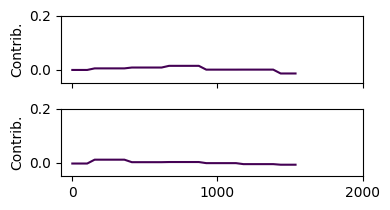

In [10]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (4, len(cents_contribs_ot) * 1.1), 'fontsize': 10,
           'sharey': True, 'sharex': True}

seqlen = exact_dict['B_dim_i'][1]


xticks = [0, int(seqlen*50 / 2), seqlen*50]

line_args = {'xticklabel': xticks, 'bounds': [-0.05, 0.2],
             'xlabel': None, 'ylabel': 'Contrib.'}

if len(cents_contribs_ot) > 1: 
    viz.MultiPlot(cents_contribs_ot, 
                **mp_args, customgrid=(len(cents_ot), 1),
                plt_mode = [viz.LinePlot, line_args]);

else: 

    viz.LinePlot(cents_contribs_ot[0], **line_args, figsize = (4, len(cents_contribs_ot) * 1.1))

In [72]:
np.nanmax(cents_contribs_ot)

np.float64(0.014134376309812069)